In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
x_train = x_train/255*2-1
x_test = x_test/255*2-1

print(x_train.shape)



(60000, 28, 28)


In [0]:
N, H, W = x_train.shape
D = H*W
x_train = x_train.reshape(-1,D)
x_test = x_test.reshape(-1,D)


In [0]:
#latent space dimension
latent_dim = 100

In [0]:
#building the generator
def build_generator(latent_dimension):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation = LeakyReLU(alpha = 0.2))(i)
  x = BatchNormalization(momentum = 0.7)(x)
  x = Dense(512, activation = LeakyReLU(alpha = 0.2))(x)
  x = BatchNormalization(momentum = 0.7)(x)
  x = Dense(1024, activation = LeakyReLU(alpha = 0.2))(x)
  x = BatchNormalization(momentum = 0.7)(x)
  x = Dense(D, activation = 'tanh')(x)
  
  model = Model(i,x)
  return model



In [0]:
#building the discriminator
def build_discriminator(image_size):
  i = Input(shape=(image_size,))
  x = Dense(512, activation = LeakyReLU(0.2))(i)
  x = Dense(256, activation = LeakyReLU(0.2))(x)
  x = Dense(1, activation = "sigmoid")(x)

  model = Model(i,x)

  return model



In [0]:
discriminator = build_discriminator(D)
discriminator.compile(optimizer = Adam(0.0002, 0.5), loss = "binary_crossentropy", metrics = ['accuracy'])

generator = build_generator(latent_dim)

z = Input(shape=(latent_dim,))

img = generator(z)

#So that the generator will get trained
discriminator.trainable = False

fake_pred = discriminator(img)

combined_model = Model(z,fake_pred)

combined_model.compile(optimizer = Adam(0.0002, 0.5), loss = "binary_crossentropy")



In [0]:
batch_size = 32
epochs = 10000
sample_period = 200 # every `sample_period` steps, the data is generated and saved

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

#folder path where images will be stored. 
if not os.path.exists("gan_images"):
  os.makedirs("gan_images")


In [0]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(H*W, latent_dim)
  images = generator.predict(noise)

  imgs = images*0.5+0.5 # images are now in a range of 0 and 1

  fig, axis = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axis[i,j].imshow(imgs[idx].reshape(H,W), cmap = "gray")
      axis[i,j].axis('off')
      idx+=1

  fig.savefig(f"gan_images/{epoch}.png")
  plt.close()


In [19]:
for epoch in range(epochs):
  #Training the discriminator
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  d_loss_real, d_acc_fake = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_real = discriminator.train_on_batch(fake_imgs, zeros)

  d_loss = 0.5*(d_loss_real + d_loss_fake)
  d_acc = 0.5*(d_acc_fake + d_acc_real)
   

  #Training the generator 
  noise = np.random.randn(batch_size, latent_dim)

  g_loss = combined_model.train_on_batch(noise, ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch:{epoch+1}/{epochs}, d-loss: {d_loss:.2f}, \
    d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch%200 ==0:
    sample_images(epoch)

epoch:1/10000, d-loss: 0.57,     d_acc: 0.72, g_loss: 1.00
epoch:101/10000, d-loss: 0.58,     d_acc: 0.69, g_loss: 1.08
epoch:201/10000, d-loss: 0.59,     d_acc: 0.72, g_loss: 1.06
epoch:301/10000, d-loss: 0.53,     d_acc: 0.77, g_loss: 1.00
epoch:401/10000, d-loss: 0.56,     d_acc: 0.69, g_loss: 0.99
epoch:501/10000, d-loss: 0.58,     d_acc: 0.75, g_loss: 0.96
epoch:601/10000, d-loss: 0.54,     d_acc: 0.77, g_loss: 1.15
epoch:701/10000, d-loss: 0.56,     d_acc: 0.78, g_loss: 1.06
epoch:801/10000, d-loss: 0.57,     d_acc: 0.70, g_loss: 1.00
epoch:901/10000, d-loss: 0.52,     d_acc: 0.78, g_loss: 1.02
epoch:1001/10000, d-loss: 0.60,     d_acc: 0.66, g_loss: 1.00
epoch:1101/10000, d-loss: 0.62,     d_acc: 0.67, g_loss: 1.09
epoch:1201/10000, d-loss: 0.58,     d_acc: 0.69, g_loss: 0.96
epoch:1301/10000, d-loss: 0.62,     d_acc: 0.67, g_loss: 0.99
epoch:1401/10000, d-loss: 0.55,     d_acc: 0.70, g_loss: 1.08
epoch:1501/10000, d-loss: 0.52,     d_acc: 0.80, g_loss: 1.02
epoch:1601/10000, d-

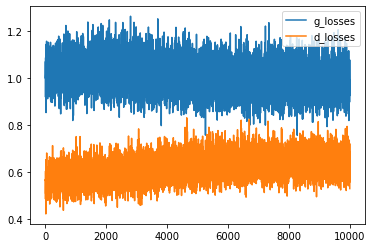

In [20]:
plt.plot(g_losses, label = "g_losses")
plt.plot(d_losses, label = "d_losses")
plt.legend()

In [21]:
!ls gan_images

0.png	  200.png   3400.png  4600.png	6000.png  7200.png  8400.png  9800.png
1000.png  2200.png  3600.png  4800.png	600.png   7400.png  8600.png
1200.png  2400.png  3800.png  5000.png	6200.png  7600.png  8800.png
1400.png  2600.png  4000.png  5200.png	6400.png  7800.png  9000.png
1600.png  2800.png  400.png   5400.png	6600.png  8000.png  9200.png
1800.png  3000.png  4200.png  5600.png	6800.png  800.png   9400.png
2000.png  3200.png  4400.png  5800.png	7000.png  8200.png  9600.png


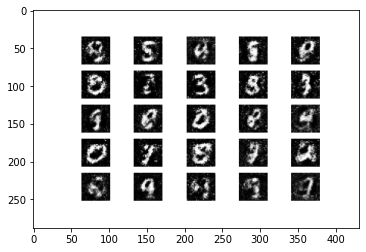

In [22]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

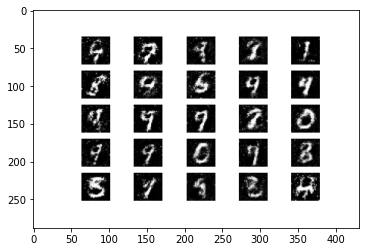

In [23]:
a = imread('gan_images/1000.png')
plt.imshow(a)

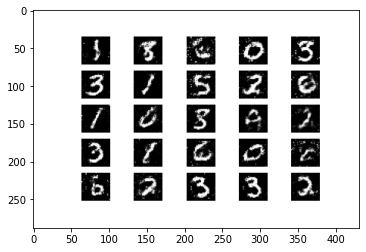

In [24]:
a = imread('gan_images/5000.png')
plt.imshow(a)

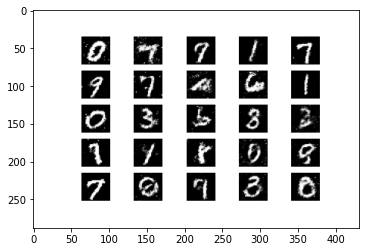

In [26]:
a = imread('gan_images/9800.png')
plt.imshow(a)

The GAN model produces more and more realistic images to the MNIST dataset as the number of epochs increases.